### TextSum - nltk frequency algorithm with an automatic query weighting

In [1]:
# Make imports and defs avaiable from utils/nlp
%run utils/nlp.ipynb

### Load Subject Corpus

In [2]:
# Run utils/text to enable load_text
%run utils/text.ipynb

In [3]:
# Load text 1 - 3, where 1 = Galileo, 2 = Mendel, 3 = Order
df=load_text(1)

text = df['text'][0]
headline = df['headline'][0]

#print(text)

In [4]:
ps = PorterStemmer()
#addStop = ['.', ',', '(', ')']

SENT_LIMIT = 35
THRESH = 1.1

def text_sum(target_text, thresh=THRESH, query=[], should_print=False):
    
    #stopWords = set().union(stopwords.words("english"), addStop)
    stopWords = set(stopwords.words("english"))
    
    word_frequencies = {}           # Dict to hold the word scores
    
    # Assign word scores
    for word in nltk.word_tokenize(target_text): 
        if word not in stopWords:
            word = ps.stem(word)
            # Apply frequency score 
            if word not in word_frequencies.keys():
                word_frequencies[word] = 1
            else:
                word_frequencies[word] += 1
    
    # Find max value from word_frequencies
    max_frequency = max(word_frequencies.values())
    
    # Normalize the word frequency between 0 and 1 with the difference from max value
    for word in word_frequencies.keys():  
        word_score = round(word_frequencies[word]/max_frequency, 3)
        word_frequencies[word] =  word_score

    # Split into a list of sentences
    sentence_list = nltk.sent_tokenize(target_text)
    sentence_scores = {}            # Dict to hold the sentence scores
    
    # Assign sentence scores
    for sent in sentence_list:  
        for word in nltk.word_tokenize(sent.lower()):
            word = ps.stem(word)
            if word in word_frequencies.keys():
                # Limit possible sentence length to SENT_LIMIT
                if len(sent.split(' ')) < SENT_LIMIT:
                    # Apply word freq score to sentences
                    if sent not in sentence_scores.keys():
                        sentence_scores[sent] = word_frequencies[word]
                        if len(query) != 0:
                        # Reward sentence if word from the query is found
                            for q in query:
                                q = ps.stem(q.lower())
                                if q in sent.lower():
                                    # Reward sentence
                                    question_bonus = round(12/max_frequency, 3)
                                    sentence_scores[sent] += question_bonus
                        # Punish the sentence if it ends with question mark
                        if sent[-1]== '?':
                            sentence_scores[sent] -= 10
                    else:
                        new_score = sentence_scores[sent] + word_frequencies[word]
                        sentence_scores[sent] = round(new_score, 3)
    
    # Sum all sentence values
    sumValues = 0
    for entry in sentence_scores:
        sumValues += sentence_scores[entry]
        
    # Average score for all sentences from original text
    average = round((sumValues / len(sentence_scores)), 3)
    
    if should_print:
        print(average)             # Shows averge score for all sentences
        print(' ')

        print(sentence_scores)     # Shows score for each sentence
        print(' ')
    
    sentence_count = 0         # Keep track of amount of sentences for future use
    summary = ''               # String to collect text summary

    # Make sure shorter texts don't vanish
    num_sentences = len(sentence_list)
   
    if num_sentences == 6:
        thresh -= 0.1
    if num_sentences == 5:
        thresh -= 0.2
    if num_sentences <= 4:
        thresh -= 0.5
    
    # Collect summary
    for sentence in sentence_list:
        if sentence in sentence_scores and sentence_scores[sentence] >= average * thresh:
            if sentence_count == 0:   # Make sure the text doesn't start with a space
                summary += sentence
                sentence_count += 1
            else:
                summary += " " + sentence
                sentence_count += 1
        

    # Make contraction when speaking about NE's. Not very frequent, but anyway
    clean_summary = clean_contractions(summary)
    
    return clean_summary

### Query creation

In [5]:
valuable_tags = ['NN','NNP','CD']    # POS list with tags to keep

# Use imports from utils/nlp.ipynb
nlp = stanfordnlp.Pipeline(processors = "tokenize,lemma,pos")

#text_nlp = nlp(text)
headline_pos = nlp(headline)

Use device: cpu
---
Loading: tokenize
With settings: 
{'model_path': '/Users/richardscheffer/stanfordnlp_resources/en_ewt_models/en_ewt_tokenizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
---
Loading: lemma
With settings: 
{'model_path': '/Users/richardscheffer/stanfordnlp_resources/en_ewt_models/en_ewt_lemmatizer.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Building an attentional Seq2Seq model...
Using a Bi-LSTM encoder
Using soft attention for LSTM.
Finetune all embeddings.
[Running seq2seq lemmatizer with edit classifier]
---
Loading: pos
With settings: 
{'model_path': '/Users/richardscheffer/stanfordnlp_resources/en_ewt_models/en_ewt_tagger.pt', 'pretrain_path': '/Users/richardscheffer/stanfordnlp_resources/en_ewt_models/en_ewt.pretrain.pt', 'lang': 'en', 'shorthand': 'en_ewt', 'mode': 'predict'}
Done loading processors!
---


In [6]:
pos_extract(headline_pos)

,word,pos
0,Galileo,NNP
1,Galilei,NNP
2,(,-LRB-
3,1564,CD
4,-,SYM
5,1642,CD
6,),-RRB-


In [7]:
pos_tags = pos_extract(headline_pos)

# Collected strings from headline pos-taggs
headline_query = create_query(pos_tags, valuable_tags) 

### Run for Summary

In [8]:
# Show query-list with result
print(headline_query)  
print(' ')

text_sum(text, thresh=1.1, query=headline_query, should_print=True)

['Galileo', 'Galilei', '1564', '1642']
 
3.183
 
{'Galileo Galilei, born in Pisa, Italy in 1564 was a key figure in the scientiﬁc revolution in Europe about four centuries ago.': 6.924, 'Galileo proposed the concept of acceleration.': 2.693, 'He thus arrived at the law of inertia that was the starting point of the subsequent epochal work of Isaac Newton.': 1.924, "Galileo's discoveries in astronomy were equally revolutionary.": 2.77, 'He concluded that the Milky Way derived its luminosity because of a large number of stars not visible to the naked eye.': 2.001, 'In his masterpiece of scientiﬁc reasoning: Dialogue on the Two Chief World Systems, Galileo advocated the heliocentric theory of the solar system proposed by Copernicus, which eventually got universal acceptance.': 5.925, 'With Galileo came a turning point in the very method of scientiﬁc inquiry.': 3.155, 'Science was no longer merely observations of nature and inferences from them.': 1.847, 'Science meant devising and doing ex

'Galileo Galilei, born in Pisa, Italy in 1564 was a key figure in the scientiﬁc revolution in Europe about four centuries ago. In his masterpiece of scientiﬁc reasoning: Dialogue on the Two Chief World Systems, Galileo advocated the heliocentric theory of the solar system proposed by Copernicus, which eventually got universal acceptance. Not undeservedly, many regard Galileo as the father of modern science.'

### Newsroom ROUGE TEST

In [9]:
%run utils/rouge.ipynb
%run utils/heatmap_sum.ipynb

In [47]:
# load 3 texts from newsroom data set
text_7, summary_7 = load_news(7)
text_70, summary_70 = load_news(70)
text_150, summary_150 = load_news(150)

In [48]:
print(summary_150)

From the wreckage of Lehman Bros., a young, pedigreed banker has a new take on using the wisdom of the crowds to help users make wise investment decisions. By Mina Kimes, writer As Lehman Brothers slid towards its demise in the summer of 2008, many of the investment bank’s younger staffers found themselves with time on their…


In [49]:
# load simulated headlines for current 3 texts
query_7 = 'Inmates continue to puff even after butt ban'
query_70 = 'Will Jenkins finally step into the field?'
query_150 = 'The Demise of Lehman Brothers turned into wisdom of the crowds'

In [ ]:
# Use def query_builder from utils/nlp to generate queries 
q_7 = query_builder(query_7)
q_70 = query_builder(query_70)
q_150 = query_builder(query_150)

In [52]:
print(q_7)
print(q_70)
print(q_150)

['butt', 'ban']
['Jenkins', 'field']
['Demise', 'Lehman', 'wisdom']


In [53]:
# Generate our NLTK TextSum summaries
comp_sum_7 = text_sum(text_7, thresh=1.1, query=q_7)
comp_sum_70 = text_sum(text_70, thresh=1.1, query=q_70)
comp_sum_150 = text_sum(text_150, thresh=1.1, query=q_150)

<Figure size 432x288 with 0 Axes>

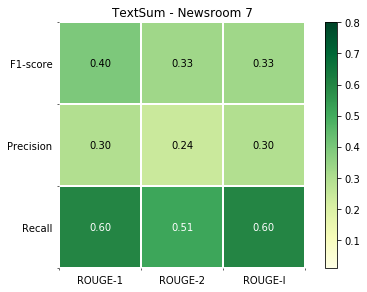

In [54]:
rouge_heatmap(comp_sum_7, summary_7)
plt.title('TextSum - Newsroom 7')
plt.show()

<Figure size 432x288 with 0 Axes>

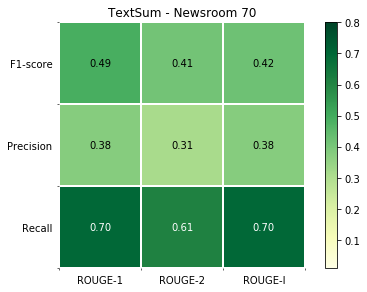

In [55]:
rouge_heatmap(comp_sum_70, summary_70)
plt.title('TextSum - Newsroom 70')
plt.show()

<Figure size 432x288 with 0 Axes>

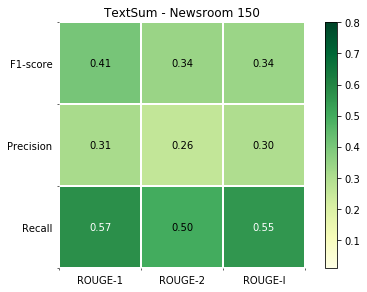

In [56]:
rouge_heatmap(comp_sum_150, summary_150)
plt.title('TextSum - Newsroom 150')
plt.show()